#1. Instalasi dan Import Library

In [16]:
# pip install pyspark

from google.colab import files
import io
from google.colab import drive
from pyspark.sql import SparkSession, Row
from pyspark.ml.evaluation import RankingEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer, MinMaxScaler, VectorAssembler
from pyspark.sql.functions import col, count, explode, collect_list, log1p, when, expr
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.pyplot as plt
import seaborn as sns


#2. Inisialisasi Spark

In [2]:
spark = SparkSession.builder.appName("MovieRecommendation").getOrCreate()

#3. Load Data

In [18]:
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = spark.read.csv(file_name, header=True, inferSchema=True)
df.show()
df.count()

Saving ratings_small.csv to ratings_small (1).csv
+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
|     1|   1129|   2.0|1260759185|
|     1|   1172|   4.0|1260759205|
|     1|   1263|   2.0|1260759151|
|     1|   1287|   2.0|1260759187|
|     1|   1293|   2.0|1260759148|
|     1|   1339|   3.5|1260759125|
|     1|   1343|   2.0|1260759131|
|     1|   1371|   2.5|1260759135|
|     1|   1405|   1.0|1260759203|
|     1|   1953|   4.0|1260759191|
|     1|   2105|   4.0|1260759139|
|     1|   2150|   3.0|1260759194|
|     1|   2193|   2.0|1260759198|
|     1|   2294|   2.0|1260759108|
|     1|   2455|   2.5|1260759113|
|     1|   2968|   1.0|1260759200|
|     1|   3671|   3.0|1260759117|
+------+-------+------+----------+
only showing top 20 rows



100004

#4. Data Pre-processing

##a. Seleksi Data

In [4]:
data = df.select("userId", "movieId", "rating")

##b. Cek Missing Values dan Duplikat Data

In [5]:
print("Missing values per column:")
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

print("Duplicate rows:")
data.groupBy(data.columns).count().where("count > 1").show()

print("Total number of duplicate rows:")
print(data.count() - data.dropDuplicates().count())

Missing values per column:
+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     0|      0|     0|
+------+-------+------+

Duplicate rows:
+------+-------+------+-----+
|userId|movieId|rating|count|
+------+-------+------+-----+
+------+-------+------+-----+

Total number of duplicate rows:
0


##c. Visualisasi Data

<Figure size 1400x600 with 0 Axes>

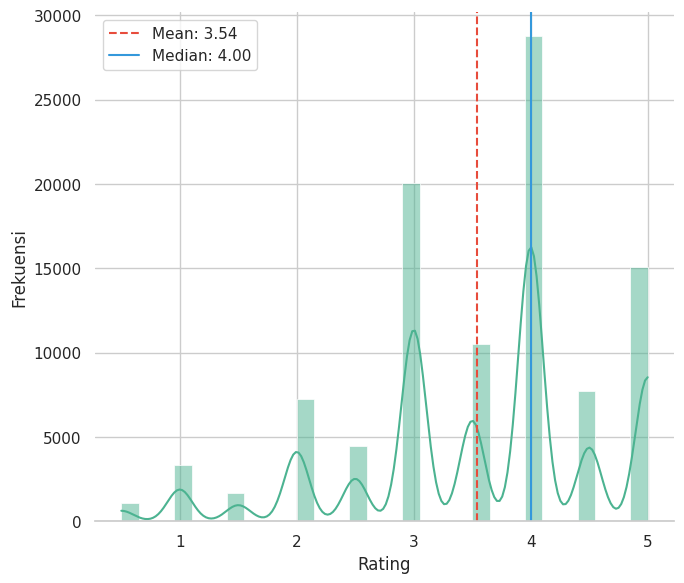

In [6]:
sns.set(style="whitegrid", palette="pastel")
data_pd = data.select("rating").toPandas()
plt.figure(figsize=(14, 6))

# Histogram with density curve without title
plt.figure(figsize=(7, 6))
ax1 = sns.histplot(data_pd["rating"], bins=30, kde=True,
                  color='#4CB391', edgecolor='white', linewidth=0.5)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Frekuensi", fontsize=12)
sns.despine(left=True)

# Add mean and median lines
mean_rating = data_pd["rating"].mean()
median_rating = data_pd["rating"].median()
ax1.axvline(mean_rating, color='#E74C3C', linestyle='--', linewidth=1.5, label=f'Mean: {mean_rating:.2f}')
ax1.axvline(median_rating, color='#3498DB', linestyle='-', linewidth=1.5, label=f'Median: {median_rating:.2f}')
ax1.legend()

plt.tight_layout()
plt.show();

In [7]:
skewness = data_pd["rating"].skew()
print(f"Skewness: {skewness:.4f}")

if skewness > 0.5:
    skew_type = "Right-skewed (positively skewed)"
elif skewness < -0.5:
    skew_type = "Left-skewed (negatively skewed)"
else:
    skew_type = "Approximately symmetrical"

print(f"Jenis Skewness: {skew_type}")

Skewness: -0.6676
Jenis Skewness: Left-skewed (negatively skewed)


##d. Split Data

In [8]:

splits = [(0.6, 0.4), (0.7, 0.3), (0.8, 0.2), (0.9, 0.1)]
best_rmse = float('inf')
best_split = None

print("Evaluasi RMSE untuk setiap split:")
for train_ratio, test_ratio in splits:
    train, test = data.randomSplit([train_ratio, test_ratio], seed=42)
    als = ALS(
        maxIter=10,
        regParam=0.1,
        userCol="userId",
        itemCol="movieId",
        ratingCol="rating",
        coldStartStrategy="drop",
        nonnegative=True,
        implicitPrefs=False
    )
    model = als.fit(train)
    predictions = model.transform(test)

    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    print(f"Split {train_ratio}:{test_ratio} - RMSE: {rmse:.4f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_split = (train_ratio, test_ratio)

print(f"\nSplit terbaik: {best_split[0]}:{best_split[1]} dengan RMSE terkecil = {best_rmse:.4f}")

trainingData, testData = data.randomSplit(list(best_split), seed=42)

Evaluasi RMSE untuk setiap split:
Split 0.6:0.4 - RMSE: 0.9408
Split 0.7:0.3 - RMSE: 0.9229
Split 0.8:0.2 - RMSE: 0.9123
Split 0.9:0.1 - RMSE: 0.8986

Split terbaik: 0.9:0.1 dengan RMSE terkecil = 0.8986


#5. Pemodelan ALS dan Hyperparameter Tuning

In [9]:
import time

ranks = [10, 15, 20, 25, 30]
regParams = [0.01, 0.05, 0.1]
maxIters = [5, 10]

best_model = None
best_rmse = float('inf')
best_params = {}

trainingData2, ValidationData = trainingData.randomSplit([0.9, 0.1], seed=42)

print("\nMulai Hyperparameter Tuning:")

for rank in ranks:
    for regParam in regParams:
        for maxIter in maxIters:
            start_time = time.time()
            als = ALS(
                maxIter=maxIter,
                rank=rank,
                regParam=regParam,
                userCol="userId",
                itemCol="movieId",
                ratingCol="rating",
                implicitPrefs=False,
                coldStartStrategy="drop",
                nonnegative=True
            )
            model = als.fit(trainingData2)
            predictions_val = model.transform(ValidationData)

            evaluator_val = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

            rmse = None
            if predictions_val.count() > 0:
                rmse = evaluator_val.evaluate(predictions_val)

            end_time = time.time()
            running_time = end_time - start_time

            if rmse is not None:
                print(f"Rank={rank}, RegParam={regParam}, MaxIter={maxIter} → RMSE: {rmse:.4f}, Running Time: {running_time:.2f} seconds")

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model
                    best_params = {"rank": rank, "regParam": regParam, "maxIter": maxIter}
            else:
                 print(f"Rank={rank}, RegParam={regParam}, MaxIter={maxIter} → No predictions generated, Skipping. Running Time: {running_time:.2f} seconds")


print(f"\nBest Model Parameters: {best_params}, RMSE: {best_rmse:.4f}")
model = best_model


Mulai Hyperparameter Tuning:
Rank=10, RegParam=0.01, MaxIter=5 → RMSE: 1.0331, Running Time: 11.72 seconds
Rank=10, RegParam=0.01, MaxIter=10 → RMSE: 1.0694, Running Time: 14.49 seconds
Rank=10, RegParam=0.05, MaxIter=5 → RMSE: 0.9515, Running Time: 10.12 seconds
Rank=10, RegParam=0.05, MaxIter=10 → RMSE: 0.9602, Running Time: 13.14 seconds
Rank=10, RegParam=0.1, MaxIter=5 → RMSE: 0.9139, Running Time: 8.11 seconds
Rank=10, RegParam=0.1, MaxIter=10 → RMSE: 0.9106, Running Time: 12.28 seconds
Rank=15, RegParam=0.01, MaxIter=5 → RMSE: 1.0426, Running Time: 10.07 seconds
Rank=15, RegParam=0.01, MaxIter=10 → RMSE: 1.0831, Running Time: 13.64 seconds
Rank=15, RegParam=0.05, MaxIter=5 → RMSE: 0.9464, Running Time: 7.52 seconds
Rank=15, RegParam=0.05, MaxIter=10 → RMSE: 0.9549, Running Time: 13.11 seconds
Rank=15, RegParam=0.1, MaxIter=5 → RMSE: 0.9004, Running Time: 9.12 seconds
Rank=15, RegParam=0.1, MaxIter=10 → RMSE: 0.9014, Running Time: 12.46 seconds
Rank=20, RegParam=0.01, MaxIter=5 →

#6. Loss Function


Training ALS iteratively with best parameters (Rank=25, RegParam=0.1):
Iteration 1...
  Training RMSE after 1 iterations: 1.4249
Iteration 2...
  Training RMSE after 2 iterations: 0.6889
Iteration 3...
  Training RMSE after 3 iterations: 0.6067
Iteration 4...
  Training RMSE after 4 iterations: 0.5747
Iteration 5...
  Training RMSE after 5 iterations: 0.5581


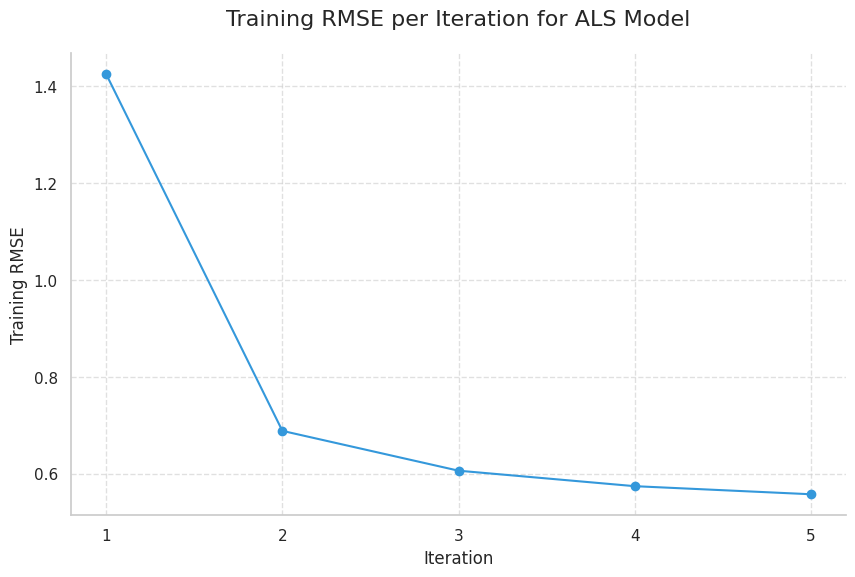

In [10]:
plt.close('all')
iterations = []
training_rmse_history = []
best_rank = best_params['rank']
best_regParam = best_params['regParam']
best_maxIter = best_params['maxIter']

print(f"\nTraining ALS iteratively with best parameters (Rank={best_rank}, RegParam={best_regParam}):")

for i in range(1, best_maxIter + 1):
    print(f"Iteration {i}...")

    als_iter = ALS(
        maxIter=i,
        rank=best_rank,
        regParam=best_regParam,
        userCol="userId",
        itemCol="movieId",
        ratingCol="rating",
        implicitPrefs=False,
        coldStartStrategy="drop",
        nonnegative=True,
        seed=42
    )
    model_iter = als_iter.fit(trainingData2)
    predictions_train = model_iter.transform(trainingData2)
    predictions_train_filtered = predictions_train.filter(col("prediction").isNotNull())

    evaluator_train = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

    if predictions_train_filtered.count() > 0:
        rmse_train = evaluator_train.evaluate(predictions_train_filtered)
        iterations.append(i)
        training_rmse_history.append(rmse_train)
        print(f"  Training RMSE after {i} iterations: {rmse_train:.4f}")
    else:
        print(f"  No valid predictions on training data after {i} iterations. Skipping RMSE calculation.")

plt.figure(figsize=(10, 6))
plt.plot(iterations, training_rmse_history, marker='o', linestyle='-', color='#3498DB')
plt.title("Training RMSE per Iteration for ALS Model", fontsize=16, pad=20)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Training RMSE", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(iterations)
sns.despine()
plt.show()



Error (Selisih RMSE) per Iterasi:
Iterasi 2 vs Iterasi 1: 0.735984
Iterasi 3 vs Iterasi 2: 0.082190
Iterasi 4 vs Iterasi 3: 0.031951
Iterasi 5 vs Iterasi 4: 0.016678


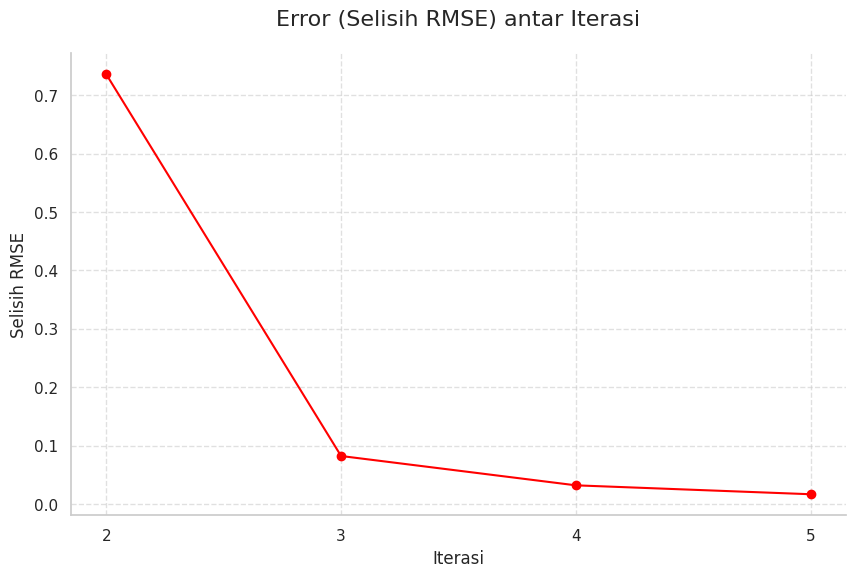

In [11]:
iteration_errors = []
for i in range(1, len(training_rmse_history)):
  error = abs(training_rmse_history[i] - training_rmse_history[i-1])
  iteration_errors.append(error)

print("\nError (Selisih RMSE) per Iterasi:")
for i, error in enumerate(iteration_errors):
  print(f"Iterasi {i+2} vs Iterasi {i+1}: {error:.6f}")

if iteration_errors:
  plt.figure(figsize=(10, 6))
  plt.plot(iterations[1:], iteration_errors, marker='o', linestyle='-', color='red')
  plt.title("Error (Selisih RMSE) antar Iterasi", fontsize=16, pad=20)
  plt.xlabel("Iterasi", fontsize=12)
  plt.ylabel("Selisih RMSE", fontsize=12)
  plt.grid(True, linestyle='--', alpha=0.6)
  plt.xticks(iterations[1:])
  sns.despine()
  plt.show()
else:
  print("Tidak cukup data untuk menghitung selisih error antar iterasi (diperlukan minimal 2 iterasi).")

#7. Evaluasi Model

##a. Membuat Rekomendasi

In [12]:
predictions = model.transform(testData)

##b. Menghitung RMSE dan MAE

In [13]:
predictions_clean = predictions.dropna(subset=["prediction", "rating"])

rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse_value = rmse_evaluator.evaluate(predictions_clean)

mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")
mae_value = mae_evaluator.evaluate(predictions_clean)

print(f"RMSE: {rmse_value:.4f}")
print(f"MAE : {mae_value:.4f}")


RMSE: 0.9034
MAE : 0.7046


#8. Tampilkan Rekomendasi

In [14]:
userRecs = model.recommendForAllUsers(10)
userRecs.show(truncate=False)

+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                                                                                                       |
+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1     |[{3672, 4.0600104}, {2361, 3.8699255}, {2563, 3.7673042}, {6413, 3.7226648}, {3963, 3.6664865}, {501, 3.6553204}, {2318, 3.6257477}, {3973, 3.6237466}, {162, 3.6112916}, {899, 3.5776465}]           |
|2     |[{83411, 5.119183}, {83359, 5.119183}, {83318, 5.119183}, {67504, 5.119183}, {1194, 4.7430634}, {3181, 4.663735}, {106920, 4.6100807}, {72647, 4.6072645}, {3154

In [21]:
userRecs_pd = userRecs.toPandas()
csv_file_path = "movie_recommendations.csv"
userRecs_pd.to_csv(csv_file_path, index=False)
files.download(csv_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>